# Project 2 Notebook # 


### Part 1: Training Model with SGD  ### 

In [2]:
import autograd.numpy as ag_np
import numpy as np
import pandas as pd
import os

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline


# %pip install autograd 

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

from CollabFilterOneVectorPerItem import CollabFilterOneVectorPerItem
from train_valid_test_loader import load_train_valid_test_datasets

DATA_DIR = './data_movie_lens_100k'
 

In [4]:
train_tuple, valid_tuple, test_tuple, n_users, n_items = load_train_valid_test_datasets()

# Hyperparameters
n_epochs = 20
batch_size = 64
step_size = 0.1
k_vals = [2, 10, 50]
alpha = 0.0  # No regularization

all_results = []
best_results = []

for k in k_vals:
    print(f"\nTraining model with k = {k}, alpha = {alpha}")
    model = CollabFilterOneVectorPerItem(
        n_epochs=n_epochs,
        batch_size=batch_size,
        step_size=step_size,
        n_factors=k,
        alpha=alpha,
    )
    model.init_parameter_dict(n_users, n_items, train_tuple)

    best_mae_valid = float('inf')
    best_epoch = 0
    best_params = None

    for epoch in range(n_epochs):
        # Train the model for one epoch
        model.fit(train_tuple, valid_tuple)

        
        #training metrics
        user_id_train, item_id_train, y_train = train_tuple
        y_pred_train = model.predict(user_id_train, item_id_train)
        mae_train = ag_np.mean(ag_np.abs(y_pred_train - y_train))
        
        # Validation metrics
        user_id_valid, item_id_valid, y_valid = valid_tuple
        y_pred_valid = model.predict(user_id_valid, item_id_valid)
#         mse_valid = ag_np.mean((y_pred_valid - y_valid) ** 2)
        mae_valid = ag_np.mean(ag_np.abs(y_pred_valid - y_valid))
        params = model.param_dict.copy()
        
#         use mae instead of mae
        if mae_valid < best_mae_valid:
            best_mae_valid = mae_valid
            best_epoch = epoch
            best_params = params

        print(
            f"Epoch {epoch + 1}/{n_epochs} - "
            f"Training MAE: {mae_train:.4f} - Validation MAE: {mae_valid:.4f}"
        )
        
        all_results.append({        
            "k": k,
            "alpha": alpha,
            "mae_train": mae_train, 
            "mae_valid": mae_valid,
            "epoch": epoch})
        
        print("ALL RESULTS: ", all_results)

    # Load the best parameters
    model.param_dict = best_params

    # Compute final MAE metrics
    user_id_test, item_id_test, y_test = test_tuple
    y_pred_test = model.predict(user_id_test, item_id_test)
    mae_test = ag_np.mean(ag_np.abs(y_pred_test - y_test))

    
    # Save best results
    best_results.append({
        "k": k,
        "alpha": alpha,
        "mae_valid": mae_valid,
        "mae_test": mae_test,
        "best_epoch": best_epoch,
        "params": best_params
    })

    print(f"Results for k={k}, alpha={alpha}:")
    print(f"  Best epoch: {best_epoch}")
    print(f"  Validation MAE: {mae_valid:.4f}")
    print(f"  Test MAE: {mae_test:.4f}")


print("\nSummary of Best Results:")
for res in best_results:
    print(
        f"k={res['k']}, "
        f"Best Validation MAE={res['mae_valid']:.4f}, "
        f"Test MAE={res['mae_test']:.4f}"
    )


Training model with k = 2, alpha = 0.0
epoch       0.000 | loss_total     0.19604 | train_MAE     3.53059 | valid_MAE     3.54504 | grad_wrt_mu     0.10498 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.001 | loss_total     0.20176 | train_MAE     3.52005 | valid_MAE     3.53450 | grad_wrt_mu     0.10660 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.002 | loss_total     0.20743 | train_MAE     3.50935 | valid_MAE     3.52380 | grad_wrt_mu     0.10725 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.003 | loss_total     0.22660 | train_MAE     3.49859 | valid_MAE     3.51304 | grad_wrt_mu     0.11277 | grad_wrt_b_per_user     0.00012 | grad_wrt_c_per_item     0.00007 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.125 | 

In [20]:
for res in best_results:
    print(f"k={res['k']}, Validation MAE={res['mae_valid']:.4f}, Test MAE={res['mae_test']:.4f}")

k=2, Validation MAE=0.7604, Test MAE=0.7558
k=10, Validation MAE=0.7605, Test MAE=0.7558
k=50, Validation MAE=0.7605, Test MAE=0.7558


Data grouped by k:
k = 2, Number of epochs: 25
k = 10, Number of epochs: 25
k = 50, Number of epochs: 25


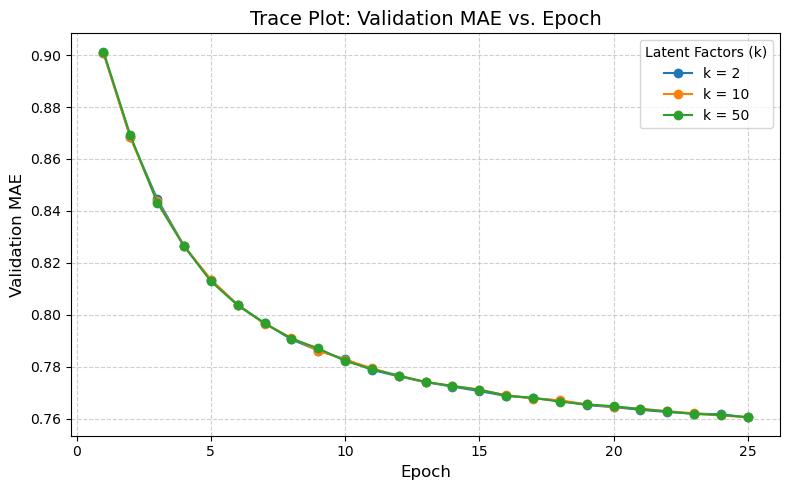

In [ ]:
import matplotlib.pyplot as plt

# Organize data by k
results_by_k = {}
for result in all_results:
    k = result["k"]
    if k not in results_by_k:
        results_by_k[k] = {"epochs": [], "mae_valid": []}
    results_by_k[k]["epochs"].append(result["epoch"] + 1)  # Convert to 1-based epoch
    results_by_k[k]["mae_valid"].append(result["mae_valid"])

# Debugging: Check data structure
print("Data grouped by k:")
for k, values in results_by_k.items():
    print(f"k = {k}, Number of epochs: {len(values['epochs'])}")

# Plotting
plt.figure(figsize=(8, 5))

for k, values in results_by_k.items():
    plt.plot(values["epochs"], values["mae_valid"], marker='o', label=f"k = {k}")

# Plot customization
plt.title("Trace Plot: Validation MAE vs. Epoch", fontsize=14)
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation MAE", fontsize=12)
plt.legend(title="Latent Factors (k)", fontsize=10)
plt.grid(True, linestyle="--", alpha=0.6)
plt.tight_layout()

# Display the plot
plt.show()


ValueError: x and y must have same first dimension, but have shapes (10,) and (0,)

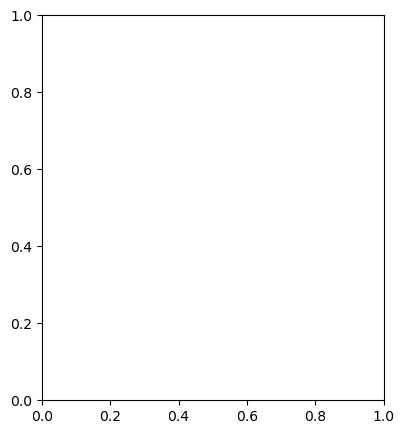

In [13]:
import matplotlib.pyplot as plt

# Extract data from the results for plotting
mae_per_epoch = {k: {'train': [], 'valid': []} for k in k_vals}

# Populate mae_per_epoch from all_results
for result in all_results:
    k = result["k"]
    mae_per_epoch[k]['train'].append(result['mae_train'])
    mae_per_epoch[k]['valid'].append(result['mae_valid'])

# Plotting the trace plots
plt.figure(figsize=(15, 5))

for idx, k in enumerate(k_vals):
    plt.subplot(1, 3, idx + 1)
    plt.plot(range(n_epochs), mae_per_epoch[k]['train'], marker='o', label="Train MAE")
    plt.plot(range(n_epochs), mae_per_epoch[k]['valid'], marker='x', label="Validation MAE")
    plt.title(f"Trace plot for k={k}")
    plt.xlabel("Epoch")
    plt.ylabel("MAE")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

# Optional: Summary of Best Results (from previous print statements)
print("\nSummary of Best Results:")
for res in best_results:
    print(f"k={res['k']}, Best Validation MAE={res['mae_valid']:.4f}, Test MAE={res['mae_test']:.4f}")


In [5]:
## training with different alpha vals ##
train_tuple, valid_tuple, test_tuple, n_users, n_items = load_train_valid_test_datasets()

# Hyperparameters
n_epochs = 10
batch_size = 64
step_size = 0.1
alpha_vals = [0.01, 0.1, 1, 10, 100]
k = 50

all_results = []
best_results = []

for alpha in alpha_vals:
    print(f"\nTraining model with k = {k}, alpha = {alpha}")
    model = CollabFilterOneVectorPerItem(
        n_epochs=n_epochs,
        batch_size=batch_size,
        step_size=step_size,
        n_factors=k,
        alpha=alpha,
    )
    model.init_parameter_dict(n_users, n_items, train_tuple)

    best_mae_valid = float('inf')
    best_epoch = 0
    best_params = None

    for epoch in range(n_epochs):
        # Train the model for one epoch
        model.fit(train_tuple, valid_tuple)

        # Validation metrics
        user_id_valid, item_id_valid, y_valid = valid_tuple
        y_pred_valid = model.predict(user_id_valid, item_id_valid)
#         mse_valid = ag_np.mean((y_pred_valid - y_valid) ** 2)
        mae_valid = ag_np.mean(ag_np.abs(y_pred_valid - y_valid))
        params = model.param_dict.copy()
    
        if mae_valid < best_mae_valid:
            best_mae_valid = mae_valid
            best_epoch = epoch
            best_params = params

        print(f"Epoch {epoch + 1}/{n_epochs} - Validation MSE: {mse_valid:.4f}")
        
        all_results.append({        
            "k": k,
            "alpha": alpha,
            "mae_valid": mae_valid,
            "epoch": epoch})
        
        print("ALL RESULTS: ", all_results)
        
    # Load the best parameters
    model.param_dict = best_params

    # Compute final MAE metrics
    user_id_test, item_id_test, y_test = test_tuple
    y_pred_test = model.predict(user_id_test, item_id_test)
    mae_test = ag_np.mean(ag_np.abs(y_pred_test - y_test))

    mae_valid = ag_np.mean(ag_np.abs(model.predict(user_id_valid, item_id_valid) - y_valid))

    # Save results
    best_results.append({
        "k": k,
        "alpha": alpha,
        "mae_valid": mae_valid,
        "mae_test": mae_test,
        "best_epoch": best_epoch,
        "params": best_params
    })

    print(f"Results for k={k}, alpha={alpha}:")
    print(f"  Best epoch: {best_epoch}")
    print(f"  Validation MAE: {mae_valid:.4f}")
    print(f"  Test MAE: {mae_test:.4f}")

# Final results summary
for res in best_results:
    print(f"k={res['k']}, Validation MAE={res['mae_valid']:.4f}, Test MAE={res['mae_test']:.4f}")


Training model with k = 50, alpha = 0.01
epoch       0.000 | loss_total     0.17971 | train_MAE     3.53059 | valid_MAE     3.54504 | grad_wrt_mu     0.09961 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.001 | loss_total     0.20912 | train_MAE     3.52058 | valid_MAE     3.53504 | grad_wrt_mu     0.11052 | grad_wrt_b_per_user     0.00012 | grad_wrt_c_per_item     0.00007 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.002 | loss_total     0.20819 | train_MAE     3.50949 | valid_MAE     3.52394 | grad_wrt_mu     0.10773 | grad_wrt_b_per_user     0.00011 | grad_wrt_c_per_item     0.00006 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.003 | loss_total     0.21087 | train_MAE     3.49868 | valid_MAE     3.51313 | grad_wrt_mu     0.10934 | grad_wrt_b_per_user     0.00012 | grad_wrt_c_per_item     0.00007 | grad_wrt_U     0.00000 | grad_wrt_V     0.00000
epoch       0.125 

NameError: name 'mse_valid' is not defined

KeyError: 'k'

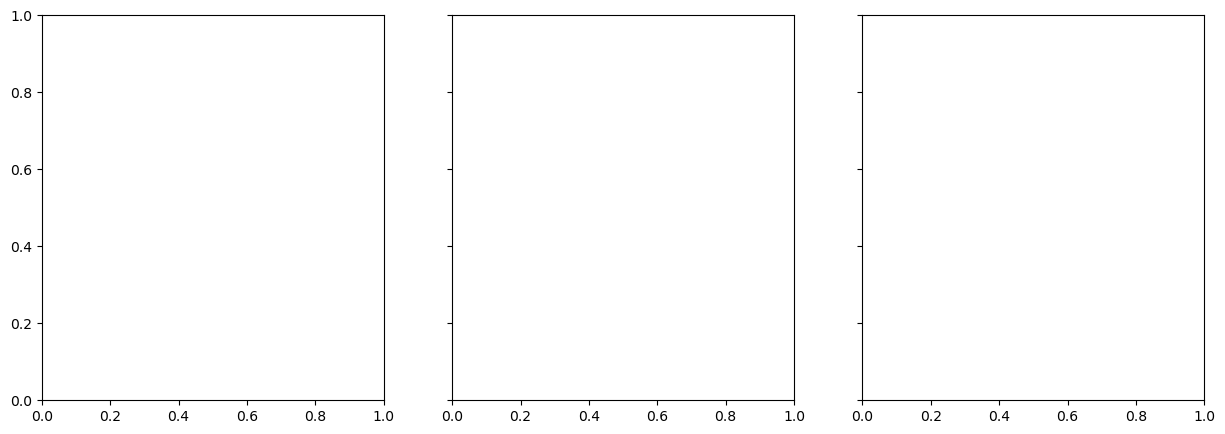

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `all_results` is already populated with the results

# Convert results to a DataFrame for easier plotting
results_df = pd.DataFrame(all_results)

# Create subplots for each value of k
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

# Plot for each value of k
k_vals = [2, 10, 50]
for i, k in enumerate(k_vals):
    k_results = results_df[results_df['k'] == k]
    
    # Plot the training and validation MAE for each epoch
    axs[i].plot(k_results['epoch'], k_results['mae_train'], label='Train MAE', marker='o')
    axs[i].plot(k_results['epoch'], k_results['mae_valid'], label='Validation MAE', marker='s')
    
    # Set the title and labels
    axs[i].set_title(f"k = {k}")
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("MAE")
    
    # Add legend
    axs[i].legend()
    axs[i].grid(True)

# Adjust layout and show the plot
plt.tight_layout()
plt.suptitle("Trace Plot of MAE vs. Epoch for Different k Values", y=1.02)
plt.show()


In [10]:
print(all_results.columns)


AttributeError: 'list' object has no attribute 'columns'

Data grouped by alpha:
alpha = 0.01, Number of epochs: 10
alpha = 0.1, Number of epochs: 10
alpha = 1, Number of epochs: 10
alpha = 10, Number of epochs: 10
alpha = 100, Number of epochs: 10


<IPython.core.display.Javascript object>


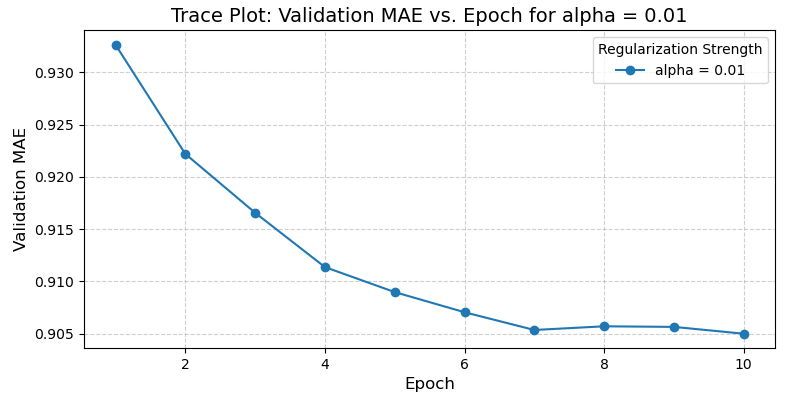

<IPython.core.display.Javascript object>


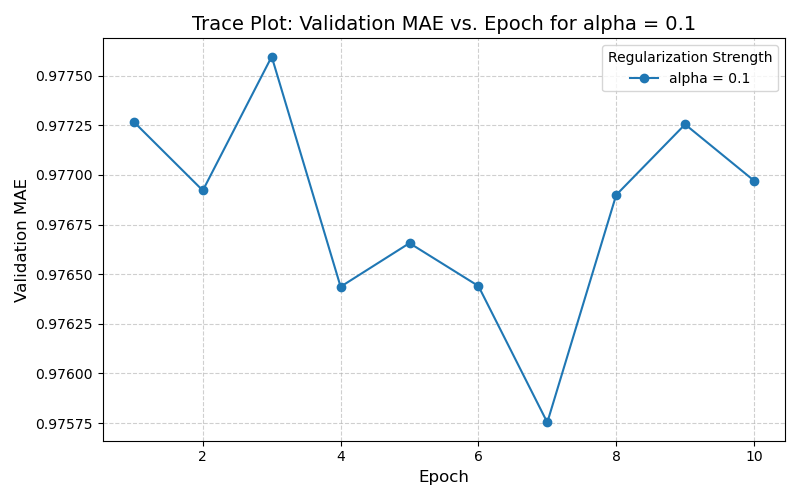

<IPython.core.display.Javascript object>


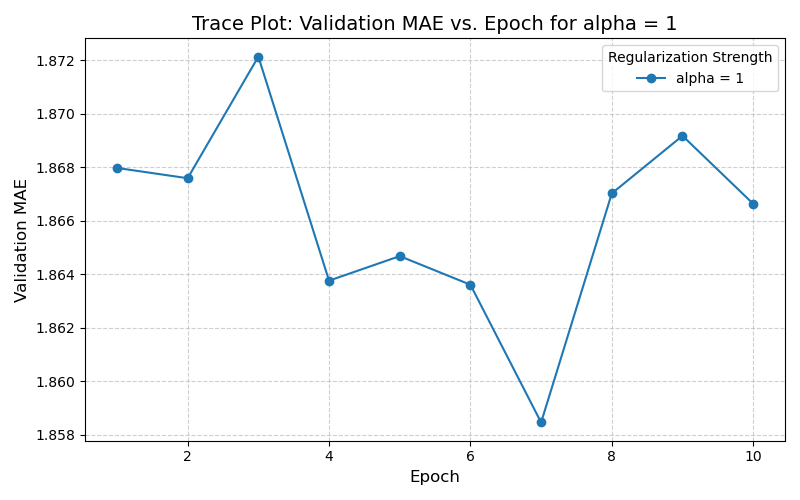

<IPython.core.display.Javascript object>


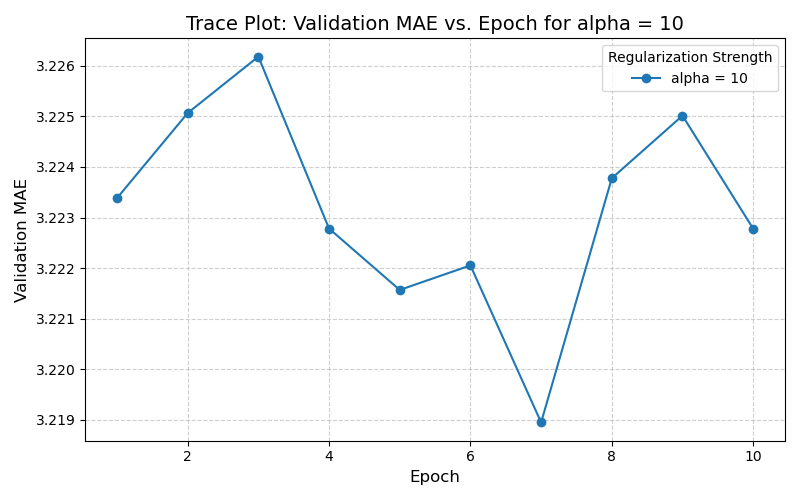

<IPython.core.display.Javascript object>


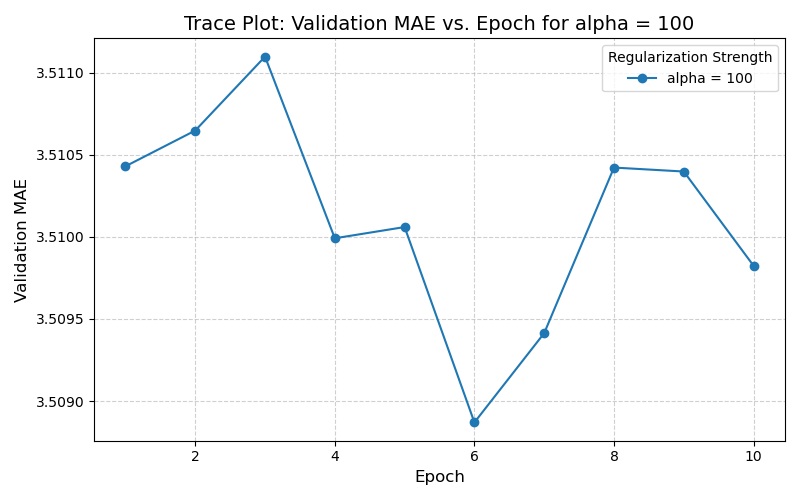

In [29]:
import matplotlib.pyplot as plt

# Organize data by alpha
results_by_alpha = {}
for result in all_results:
    alpha = result["alpha"]
    if alpha not in results_by_alpha:
        results_by_alpha[alpha] = {"epochs": [], "mae_valid": []}
    results_by_alpha[alpha]["epochs"].append(result["epoch"] + 1)  # Convert to 1-based epoch
    results_by_alpha[alpha]["mae_valid"].append(result["mae_valid"])

# Debugging: Check grouped data
print("Data grouped by alpha:")
for alpha, values in results_by_alpha.items():
    print(f"alpha = {alpha}, Number of epochs: {len(values['epochs'])}")

# Create separate plots for each alpha
for alpha, values in results_by_alpha.items():
    plt.figure(figsize=(8, 5))
    plt.plot(values["epochs"], values["mae_valid"], marker='o', label=f"alpha = {alpha}")

    # Customize plot
    plt.title(f"Trace Plot: Validation MAE vs. Epoch for alpha = {alpha}", fontsize=14)
    plt.xlabel("Epoch", fontsize=12)
    plt.ylabel("Validation MAE", fontsize=12)
    plt.legend(title="Regularization Strength", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Show plot
    plt.show()


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-win_amd64.whl size=1290799 sha256=50d7b576d5e33b84e3a224bba99e6a5060faca60e5a75687f15122108c565787
  Stored in directory: c:\users\jonch\appdata\local\pip\cache\wheels\4b\3f\df\6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise
  Using cached scikit_surprise-1.1.4.tar.gz (154 kB)
  Installing build dependencies: started
  Installing build dependencies: still running...
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.


MAE:  0.7346
Test MAE: 0.7345530423263658


c:\Users\jonch\micromamba\envs\cs135_env\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\jonch\micromamba\envs\cs135_env\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


MAE:  0.5262
Test MAE: 0.526227546192234


Best parameters: {'n_factors': 200, 'reg_all': 0.1, 'lr_all': 0.005, 'n_epochs': 100}
Test MAE: 0.526227546192234
